# Location

In [1]:
import os

# In Colab, the notebook is mounted in Google Drive at '/content'

# Try to detect the environment dynamically
if 'COLAB_GPU' in os.environ:  # Check if running in Colab
    # Colab path where the notebook is located
    notebook_directory = '/content/drive/MyDrive/airbnb_project/notebooks/'
elif os.path.exists('/airbnb_project/notebooks'):  # Check if running in Docker
    # Docker path where the notebook is located
    notebook_directory = '/airbnb_project/notebooks/'
else:
    # Default fallback if not in either environment
    notebook_directory = os.getcwd()

# Change the current working directory to the notebook's location
os.chdir(notebook_directory)

# Verify the current directory
print("Current directory:", os.getcwd())


Current directory: /airbnb_project/notebooks


In [2]:
print("hola")

hola


# Libraries

In [ ]:
import sys
sys.path.append('../src')

In [ ]:
# Install PySpark
%pip install pyspark

import sys
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, DateType, LongType
import pyspark.sql.functions as F
from pyspark.sql.functions import col, to_date, when, date_format
from pyspark.sql.functions import avg, count
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf
from transformations import format_date

# Locating files

In [ ]:
# Upload XLSX
df = pd.read_excel('../datasets/listings_details.xlsx')


The files are xlsx but Spark is designed works better with csv. So xlsx will be converted into csv

In [ ]:
# Upload XLSX
df = pd.read_excel('../datasets/listings_details.xlsx')

# Replace line breaks with spaces
df = df.replace({r'[\n\r]+': ' '}, regex=True)

# Replace " with '
df = df.replace({r'"': "'"}, regex=True)

# Save CSV
df.to_csv('../datasets/listings_details.csv', index=False, quotechar='"')

In [ ]:
# Upload XLSX
df2 = pd.read_excel('../datasets/neighbourhoods.xlsx')

# Replace line breaks with spaces
df2 = df2.replace({r'[\n\r]+': ' '}, regex=True)

# Save CSV
df2.to_csv('../datasets/neighbourhoods.csv', index=False)

# PART 1: Landing Zone

In [ ]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("MedallionArchitecture") \
    .getOrCreate()

In [ ]:
# Define the columns you need
columns_needed = ["id", "listing_url", "host_id", "neighbourhood",
                  "neighbourhood_cleansed", "number_of_reviews",
                  "review_scores_rating", "last_review"]

# Read listings_details.csv
listings_details = spark.read.option("header", True)\
  .csv("../datasets/listings_details.csv")

# Select only the necessary columns
listings_details = listings_details.select(*columns_needed)

# Apply the schema
listings_details = listings_details\
  .withColumn('id', F.col('id').cast(LongType()))\
  .withColumn('number_of_reviews', F.col('number_of_reviews').cast(DoubleType()))\
  .withColumn('review_scores_rating', F.col('review_scores_rating').cast(DoubleType()))
  #.withColumn('last_review', F.col('last_review').cast(DateType()))

# Read neighbourhoods.csv
neighbourhoods = spark.read.option("header", True)\
  .csv("../datasets/neighbourhoods.csv")

In [ ]:
# Print the schema of the DataFrame
listings_details.printSchema()

root
 |-- id: long (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- number_of_reviews: double (nullable = true)
 |-- review_scores_rating: double (nullable = true)
 |-- last_review: string (nullable = true)



In [ ]:
# Show the first 5 rows
listings_details.show(5)

+------+--------------------+-------+--------------------+----------------------+-----------------+--------------------+-----------+
|    id|         listing_url|host_id|       neighbourhood|neighbourhood_cleansed|number_of_reviews|review_scores_rating|last_review|
+------+--------------------+-------+--------------------+----------------------+-----------------+--------------------+-----------+
| 73282|https://www.airbn...| 377532|                NULL|              Sihlfeld|             47.0|                4.78| 2019-04-27|
|143821|https://www.airbn...| 697307|                NULL|          Alt-Wiedikon|              0.0|                NULL|       NULL|
|178448|https://www.airbn...| 854016| Zurich, Switzerland|                  Enge|              9.0|                4.89| 2016-05-10|
|204586|https://www.airbn...|1004816|                NULL|                 Höngg|              0.0|                NULL|       NULL|
|227039|https://www.airbn...|1184427|Zurich, Canton of...|           

In [ ]:
# If exists, delete directory structure
! rm -rf "../tables"

In [ ]:
# Create directory structure
! mkdir "../tables"
! mkdir "../tables/bronze"
! mkdir "../tables/silver"
! mkdir "../tables/gold"

# PART 2: Bronze Layer

In [ ]:
# Write raw data to Bronze layer in Parquet format

# Bronze paths
bronze_path = "../tables"
layer = "bronze"
listings_filename = "bronze_listings_details"
neighbourhoods_filename = "neighbourhoods"


bronze_listing_output_file = "{path}/{layer}/{filename}".format(path=bronze_path, layer=layer, filename=listings_filename)
listings_details.write.mode( "overwrite" ).parquet(bronze_listing_output_file)

bronze_neighbourhoods_output_file = "{path}/{layer}/{filename}".format(path=bronze_path, layer=layer, filename=neighbourhoods_filename)
neighbourhoods.write.mode( "overwrite" ).parquet(bronze_neighbourhoods_output_file)

# PART 3: Silver Layer

In [ ]:
# Silver paths
silver_listing_input_file = bronze_listing_output_file
silver_neighbourhoods_input_file = bronze_neighbourhoods_output_file

# Load Bronze data
bronze_listingsDF = spark.read.parquet(silver_listing_input_file)
bronze_neighbourhoodsDF = spark.read.parquet(silver_neighbourhoods_input_file)

In [ ]:
# add Python file to the PySpark context, which makes it available on all worker nodes of the Spark cluster when running distributed operations.
spark.sparkContext.addPyFile('../src/transformations.zip')

In [ ]:
# Register the function as a UDF so that it can be executed in each partition of the cluster
format_date_udf = udf(format_date, StringType())

In [ ]:
# Join datasets and create new fields
join_silver_listingsDF = bronze_listingsDF.join(
    bronze_neighbourhoodsDF,
    bronze_listingsDF["neighbourhood_cleansed"] == bronze_neighbourhoodsDF["neighbourhood"],
    "left"
).withColumn(
    "neighbourhood_group", col("neighbourhood_group")
).withColumn(
    "last_review_human", format_date_udf(col("last_review"))
).drop(
    bronze_neighbourhoodsDF["neighbourhood"]
)


In [ ]:
# Display all columns from the DataFrame
join_silver_listingsDF.show(10, truncate=False)

+------+-----------------------------------+-------+-------------------------------------+----------------------+-----------------+--------------------+-----------+-------------------+----------------------+
|id    |listing_url                        |host_id|neighbourhood                        |neighbourhood_cleansed|number_of_reviews|review_scores_rating|last_review|neighbourhood_group|last_review_human     |
+------+-----------------------------------+-------+-------------------------------------+----------------------+-----------------+--------------------+-----------+-------------------+----------------------+
|73282 |https://www.airbnb.com/rooms/73282 |377532 |NULL                                 |Sihlfeld              |47.0             |4.78                |2019-04-27 |Kreis 3            |Saturday 27 April 2019|
|143821|https://www.airbnb.com/rooms/143821|697307 |NULL                                 |Alt-Wiedikon          |0.0              |NULL                |NULL       |Krei

In [ ]:
# Write data to Silver layer
silver_listings_path = "../tables/silver/silver_listings_details"
join_silver_listingsDF.write.mode("overwrite").parquet(silver_listings_path)

# PART 4: Gold Layer

In [ ]:
# Load Silver data
silver_listings = spark.read.parquet(silver_listings_path)

# Calculate metrics
id_gold_listings = silver_listings\
  .groupBy("id").agg(
    count("number_of_reviews").alias("id_rating_count"),
    avg("review_scores_rating").alias("id_rating_avg"))

# Join neighbourhood_group to id_gold_listings
id_gold_listings = id_gold_listings.join(
    silver_listings.select("id", "neighbourhood_group"),
    on="id",
    how="left")

# Calculate metrics
group_gold_listings = silver_listings\
  .groupBy("neighbourhood_group").agg(
    count("number_of_reviews").alias("ng_rating_count"),
    avg("review_scores_rating").alias("ng_rating_avg"))

# Gold DF
gold_listings = id_gold_listings.join(
    group_gold_listings.select("neighbourhood_group","ng_rating_count", "ng_rating_avg"),
    on="neighbourhood_group",
    how="left")

# Write data to Gold layer
gold_listings_path = "../tables/gold/dasboard_ng_ratings"
gold_listings.write.mode("overwrite").parquet(gold_listings_path)

# PART 5: Presentation

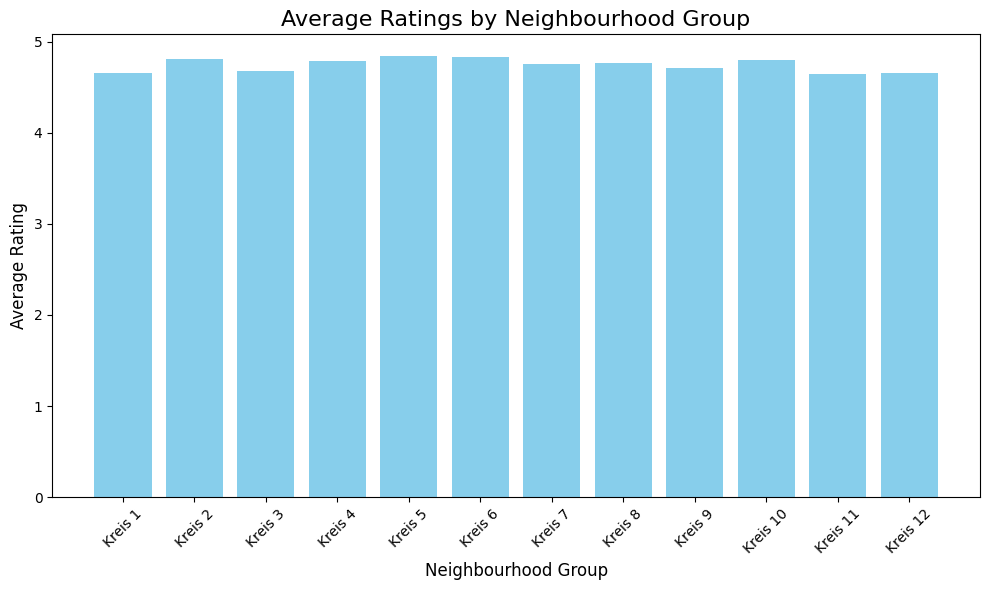

In [ ]:
# Load Gold data
gold_listings = spark.read.parquet(gold_listings_path)

# Convert Gold data to Pandas for plotting
gold_pandas = gold_listings.toPandas()

# Define the order of the neighborhood groups
order = ['Kreis 1', 'Kreis 2', 'Kreis 3', 'Kreis 4', 'Kreis 5', 'Kreis 6', 'Kreis 7', 'Kreis 8', 'Kreis 9', 'Kreis 10', 'Kreis 11', 'Kreis 12']

# Convert the 'neighbourhood_group' column to a categorical type with the specified order
gold_pandas['neighbourhood_group'] = pd.Categorical(gold_pandas['neighbourhood_group'], categories=order, ordered=True)


# Sort the data by neighbourhood_group
gold_pandas = gold_pandas.sort_values("neighbourhood_group")

# Export Gold data to CSV for visualization
gold_csv_path = "../datasets/dashboard_ng_ratings.csv"
gold_pandas.to_csv(gold_csv_path, index=False)

# Plot neighborhood group ratings
plt.figure(figsize=(10, 6))
plt.bar(gold_pandas["neighbourhood_group"], gold_pandas["ng_rating_avg"], color='skyblue')
plt.title("Average Ratings by Neighbourhood Group", fontsize=16)
plt.xlabel("Neighbourhood Group", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()